In [1]:
import sys

sys.path.append("../")

In [2]:
import torch
from torch.utils.data import DataLoader

import hydra

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from src.models.core_models.zero_shot_ris.freesolo import CustomFreeSOLO
from src.data.core_datasets.zeroshot_dataset import ZeroShotDataset

In [3]:
with hydra.initialize(version_base="1.3", config_path="../configs/model"):
    cfg = hydra.compose(config_name="zsseg.yaml")
cfg

{'_target_': 'src.models.image_text_mask_module.ImageTextMaskModule', 'net': {'_target_': 'src.models.core_models.zero_shot_ris.ZeroShotRIS', 'clip_pretrained_path': '${model_pretrained_path}', 'is_hf_model': '${is_hf_model}', 'clip_interpolation_mode': '${import_eval:torchvision.transforms.functional.InterpolationMode.BICUBIC}', 'solo_config': {'MODEL': {'ANCHOR_GENERATOR': {'ANGLES': [[-90, 0, 90]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'NAME': 'DefaultAnchorGenerator', 'OFFSET': 0.0, 'SIZES': [[32, 64, 128, 256, 512]]}, 'BACKBONE': {'FREEZE_AT': 0, 'NAME': 'build_resnet_fpn_backbone'}, 'FPN': {'FUSE_TYPE': 'sum', 'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'NORM': '', 'OUT_CHANNELS': 256}, 'KEYPOINT_ON': False, 'LOAD_PROPOSALS': False, 'MASK_ON': True, 'META_ARCHITECTURE': 'PseudoSOLOv2', 'PANOPTIC_FPN': {'COMBINE': {'ENABLED': True, 'INSTANCES_CONFIDENCE_THRESH': 0.5, 'OVERLAP_THRESH': 0.5, 'STUFF_AREA_LIMIT': 4096}, 'INSTANCE_LOSS_WEIGHT': 1.0}, 'PIXEL_MEAN': [123.675, 116.28, 

In [31]:
solo_config = cfg.net.solo_config

In [59]:
solo_config.MODEL.SOLOV2.MAX_PER_IMG = 200
solo_config.MODEL.SOLOV2.MAX_PER_IMG

200

In [60]:
pretrained_path = "openai/clip-vit-base-patch32"
# pretrained_path = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract"

In [61]:
# img_size = 224
# extracted from the config
img_mean= [0.485, 0.456, 0.406]
img_std= [0.229, 0.224, 0.225] 

In [62]:
transforms = A.Compose([    
    # A.Resize(height=img_size, width=img_size, interpolation=cv2.INTER_CUBIC),
    A.Normalize(mean=img_mean,std=img_std),
    ToTensorV2(transpose_mask=True)
])

In [63]:
ds= ZeroShotDataset(
  images_dir="../data/kvasir_polyp/images",
  masks_dir="../data/kvasir_polyp/masks",
  caps_file="../data/kvasir_polyp/anns/test.json",
  tokenizer_pretrained_path=pretrained_path,
  prompt_type="p6",
  object_class="polyp",
  transforms= transforms,
  return_tensors= "pt",
)

In [64]:
dl = DataLoader(ds, num_workers=2)

In [65]:
sample = next(iter(dl))
sample

{'image': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
    

In [66]:
sample["image"].shape

torch.Size([1, 3, 529, 621])

In [67]:
sample["input_ids"].shape

torch.Size([1, 2, 15])

In [68]:
image_input = sample["image"]

In [69]:
solo = CustomFreeSOLO(solo_config, "../pretrain/FreeSOLO_R101_30k.pt")

In [70]:
from monai.metrics import MeanIoU, compute_iou, DiceHelper

iou_helper = MeanIoU(reduction="mean_channel")
dice_helper = DiceHelper(reduction="mean_channel")

In [71]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [72]:
solo.to(device)
solo.eval();

In [73]:
max_dices = []
max_ious = []

with torch.inference_mode():
    for i, batch in enumerate(dl, 1):
        image_input = batch["image"].to(device)
        mask = batch["mask"].to(device)
        
        pred_boxes, pred_masks = solo(image_input[0])

        print(f"{i}/{len(dl)}: Num Masks Predicted", pred_masks.size(0))

        pred_with_channel = pred_masks.unsqueeze(1)
        expanded_mask = mask.expand(pred_with_channel.size(0), -1, -1, -1)
        
        f, non_nans = dice_helper(pred_with_channel, expanded_mask)
        dice = f.max().item()
        
        g = iou_helper(pred_with_channel, expanded_mask)
        iou = g.max().item()
        
        max_dices.append(dice)
        max_ious.append(iou)

1/100: Num Masks Predicted 62
2/100: Num Masks Predicted 70
3/100: Num Masks Predicted 71
4/100: Num Masks Predicted 79
5/100: Num Masks Predicted 50
6/100: Num Masks Predicted 70
7/100: Num Masks Predicted 82
8/100: Num Masks Predicted 78
9/100: Num Masks Predicted 80
10/100: Num Masks Predicted 67
11/100: Num Masks Predicted 62
12/100: Num Masks Predicted 92
13/100: Num Masks Predicted 59
14/100: Num Masks Predicted 86
15/100: Num Masks Predicted 64
16/100: Num Masks Predicted 72
17/100: Num Masks Predicted 35
18/100: Num Masks Predicted 79
19/100: Num Masks Predicted 42
20/100: Num Masks Predicted 58
21/100: Num Masks Predicted 98
22/100: Num Masks Predicted 84
23/100: Num Masks Predicted 61
24/100: Num Masks Predicted 42
25/100: Num Masks Predicted 57
26/100: Num Masks Predicted 61
27/100: Num Masks Predicted 52
28/100: Num Masks Predicted 71
29/100: Num Masks Predicted 58
30/100: Num Masks Predicted 79
31/100: Num Masks Predicted 52
32/100: Num Masks Predicted 48
33/100: Num Masks

In [74]:
len(f), f.argmax()

(67, tensor(23, device='cuda:0'))

In [75]:
np_image = image_input[0].cpu().movedim(0, -1).numpy()
last_mask = mask.squeeze().cpu().numpy()
best_pred = pred_masks[f.argmax()].cpu().numpy()

In [76]:
def mean(x):
    return sum(x) / len(x)

In [77]:
mean(max_dices), mean(max_ious)

(0.766451314240694, 0.6514586341008544)

In [78]:
from matplotlib import pyplot as plt

import numpy as np

In [79]:
def rescale_img(img):
    img_min = img.min((0, 1))
    return (img - img_min) / (img.max((0, 1)) - img_min)

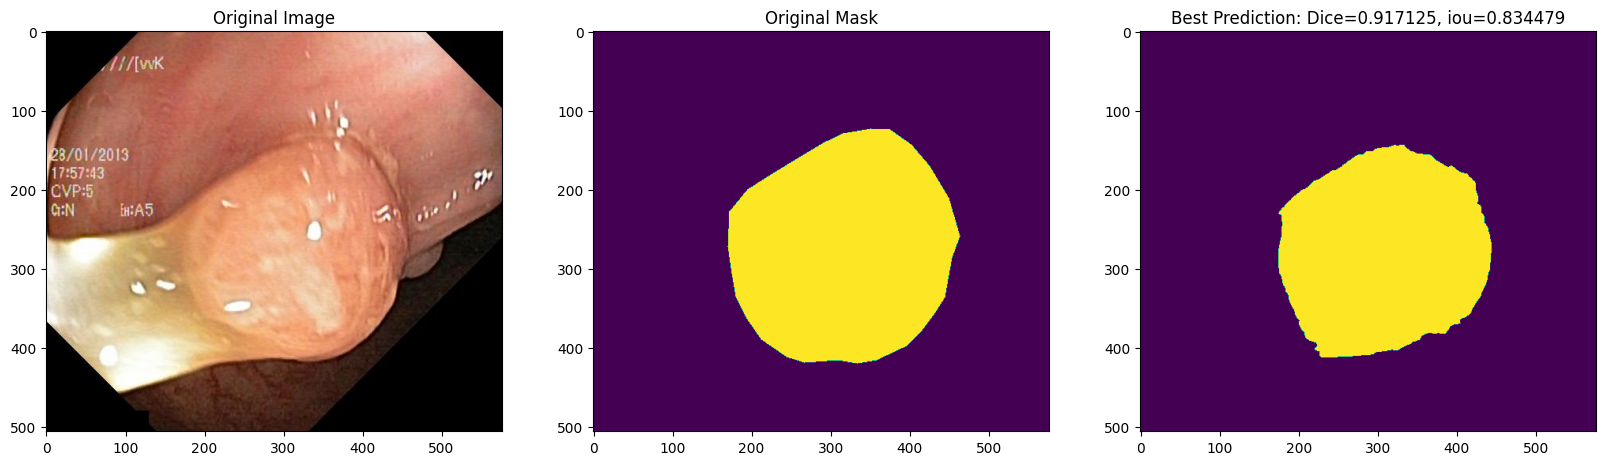

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

ax1.imshow(rescale_img(np_image))
ax1.set_title("Original Image")

ax2.imshow(last_mask)
ax2.set_title("Original Mask")

ax3.imshow(best_pred)
ax3.set_title(f"Best Prediction: Dice={dice:4f}, iou={iou:4f}");

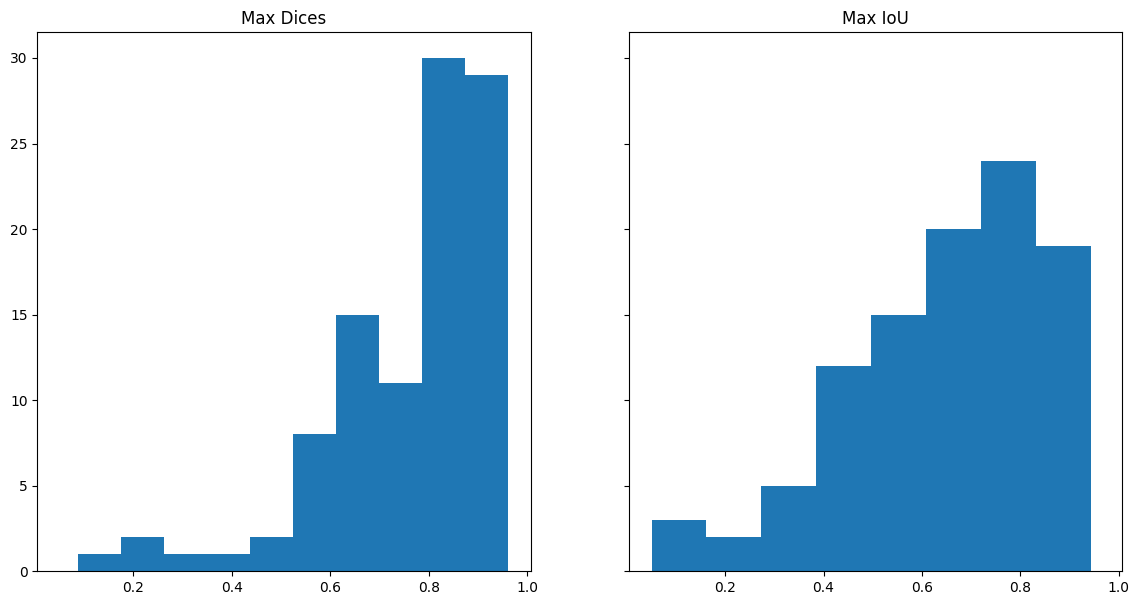

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14, 7))

ax1.hist(max_dices, bins="auto")
ax1.set_title("Max Dices")

ax2.hist(max_ious, bins="auto")
ax2.set_title("Max IoU");

In [57]:
last_dices = f.cpu().numpy()
last_dices

array([0.0000000e+00, 8.9111137e-01, 0.0000000e+00, 2.5530981e-02,
       0.0000000e+00, 2.0162565e-01, 4.5856595e-01, 5.2721024e-01,
       5.6759058e-04, 2.4380406e-02, 0.0000000e+00, 4.8656069e-02,
       0.0000000e+00, 2.4877055e-01, 7.0312309e-01, 4.0920633e-01,
       7.1808964e-01, 0.0000000e+00, 2.4163345e-04, 6.0716891e-01,
       8.7346518e-01, 0.0000000e+00, 9.1421366e-01, 9.1712463e-01,
       5.7594186e-01, 4.3620799e-02, 0.0000000e+00, 4.4031024e-01,
       7.8699589e-01, 0.0000000e+00, 1.5927032e-01, 6.4320093e-01,
       7.6555169e-01, 4.7367554e-02, 1.2308729e-01, 1.0279043e-02,
       0.0000000e+00, 1.4474432e-01, 8.7157136e-01, 0.0000000e+00,
       7.5344723e-01, 0.0000000e+00, 5.8752668e-01, 2.3179795e-01,
       8.4570974e-01, 0.0000000e+00, 1.2955299e-01, 6.2572765e-01,
       9.0431291e-01, 8.7751263e-01, 6.5543330e-01, 0.0000000e+00,
       7.6725912e-01, 0.0000000e+00, 7.3915929e-01, 0.0000000e+00,
       5.5317707e-02, 7.7091187e-01, 0.0000000e+00, 0.0000000e

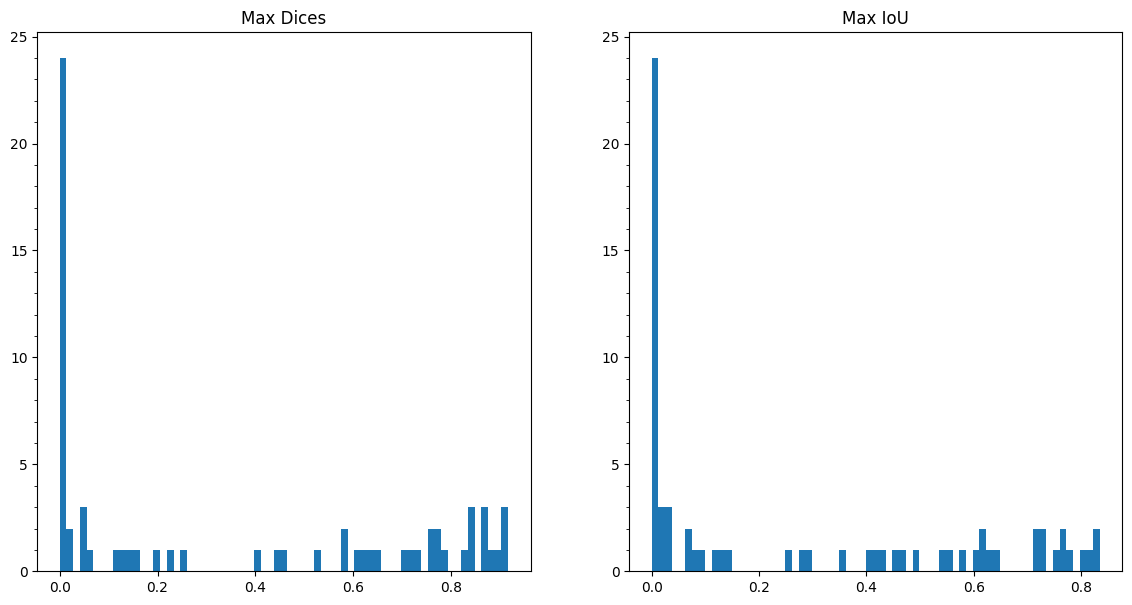

In [58]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

autolocator = AutoMinorLocator()

ax1.hist(f.cpu().numpy(), bins=len(f))
ax1.yaxis.get_major_locator().set_params(integer=True)
ax1.yaxis.set_minor_locator(autolocator)
ax1.set_title("Max Dices")

ax2.hist(g.cpu().numpy(), bins=len(g))
ax2.yaxis.get_major_locator().set_params(integer=True)
ax2.yaxis.set_minor_locator(autolocator)
ax2.set_title("Max IoU");